In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from   sklearn.neighbors import KernelDensity
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ADSK','AMZN', 'ANET', 'APPH', 'AXON', 
    'BBY','BROS', 'BYND', 'CDNS', 'COUR', 'CRWD', 'DDOG', 'DOCU', 
    'DUOL', 'EDIT', 'ETSY', 'FTCH', 'FUV', 'FVRR', 'GH', 'GMED', 'GOOG',
    'INTG', 'ISRG', 'JD', 'LSPD', 'LULU', 'MDB', 'MELI', 'MNST', 'MSFT', 
    'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW', 'PINS', 
    'PTON', 'PUBM', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'ROST', 
    'SE', 'SHOP', 'SPGI', 'SPLK', 'SQ', 'TDOC','TEAM', 'TREX', 'TRUP', 
    'TSLA', 'TTD', 'TTWO', 'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'ZEN', 
    'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

70

In [3]:
TODAY = (datetime.now() + timedelta(1)).date()
START = TODAY - timedelta(5*365)
START, TODAY

(datetime.date(2016, 11, 7), datetime.date(2021, 11, 6))

In [4]:
batch = SYMBOLS + INDICES

In [5]:
data = yf.download(batch, start=START, end=TODAY).rename(columns={'Adj Close': 'AdjClose'})

[*********************100%***********************]  73 of 73 completed


In [6]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [7]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [8]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [9]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [10]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [11]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [12]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    sharpe = get_sharpe(get_daily_returns(stock_data.AdjClose))
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    n = stock_data.shape[0]
    WINDOW = min(n, 125)
    stock_data['ann_high'] = (stock_data.Close
                              .rolling(window=WINDOW)
                              .max())
    stock_data['ann_low'] = (stock_data.Close
                             .rolling(window=WINDOW)
                             .min())
    stock_data['drawdown'] = stock_data.Close / stock_data.ann_high
    stock_data['pullup'] = stock_data.Close / stock_data.ann_low
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = ((stock_data.Close 
                            + stock_data.High 
                            + stock_data.Low 
                            + stock_data.Open) 
                           / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.Close / stock_data.est
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(np.sqrt(stock_data.drawdown * stock_data.pullup),
                 color='grey',
                 label='geomean')
        plt.yscale('log')
        plt.legend()
    return (stock_data.direction.tolist()[-1],
            stock_data.rsi.tolist()[-1],
            stock_data.resid.tolist()[-1], 
            stock_data.dev.tolist()[-1],
            stock_data.drawdown.tolist()[-1],
            stock_data.pullup.tolist()[-1],
            sharpe)

(1,
 68.73746822611427,
 1.057400141579049,
 0.9523431294678316,
 0.9168582492404513,
 1.1336933910171652,
 0.5745937821254257)

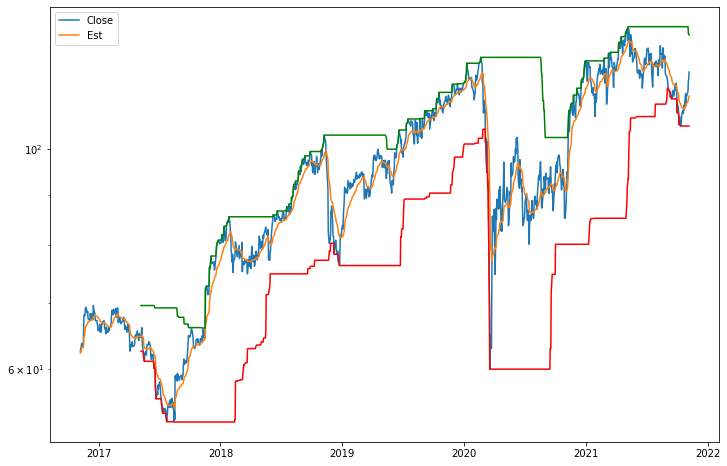

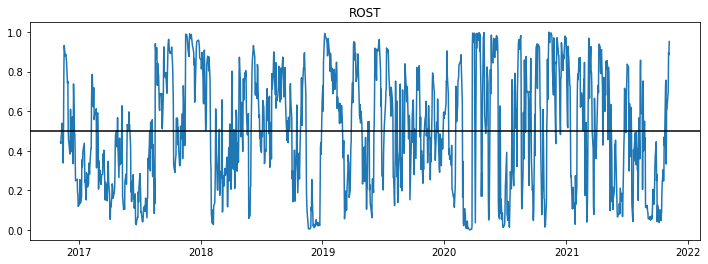

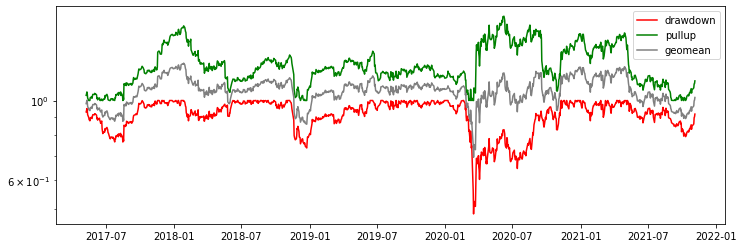

In [13]:
process_stock('ROST', data.copy(), plot=True)

In [14]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    direction, rsi, mult, dev, drop, climb, sharpe = process_stock(
        stock, data)
    out.append([stock, direction, rsi, mult, dev, drop, climb, sharpe])

AAPL... ABMD... ABNB... ADSK... AMZN... ANET... APPH... AXON... BBY... BROS... BYND... CDNS... COUR... CRWD... DDOG... DOCU... DUOL... EDIT... ETSY... FTCH... FUV... FVRR... GH... GMED... GOOG... INTG... ISRG... JD... LSPD... LULU... MDB... MELI... MNST... MSFT... MTCH... NVCR... NVDA... NYT... OKTA... OPEN... PANW... PINS... PTON... PUBM... QDEL... RBLX... RDFN... RGEN... ROKU... ROST... SE... SHOP... SPGI... SPLK... SQ... TDOC... TEAM... TREX... TRUP... TSLA... TTD... TTWO... TWLO... TWTR... UPST... VEEV... WK... ZEN... ZG... ZNGA... ^GSPC... ^IXIC... ^NYA... 

In [15]:
out = pd.DataFrame(
    data=out, 
    columns=['stock', 'direction', 'RSI', 'fair_value_mult', 
             'dev_quantile', 'drop','climb', 'sharpe'])
out['geomean'] = np.sqrt(out['drop'] * out.climb)
out.loc
out['score'] = (out.fair_value_mult
                * out.dev_quantile
                * out['drop']
                * out.climb) ** (1/4) 
out.RSI *= 100
out['RSIRev'] = 10000 - out.RSI
out = out[['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
           'dev_quantile', 'drop', 'climb','geomean', 'score', 
           'sharpe']]
out.RSI.fillna(out.RSI.median())
out.RSIRev.fillna(out.RSIRev.median())

out.sort_values('score')

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe
42,PTON,0,2022.943067,7977.056933,0.769452,0.001873,0.438386,1.000000,0.662108,0.158535,0.890437
68,ZG,0,3090.483207,6909.516793,0.833176,0.014297,0.531102,1.004707,0.730481,0.282358,0.512831
69,ZNGA,1,3448.793896,6551.206104,0.934169,0.038920,0.618280,1.000000,0.786308,0.387209,0.678053
28,LSPD,0,3132.786410,6867.213590,0.893961,0.047945,0.587252,1.311670,0.877656,0.426264,1.426472
44,QDEL,0,3538.223544,6461.776456,0.909119,0.045274,0.769769,1.163640,0.946432,0.438190,0.936220
...,...,...,...,...,...,...,...,...,...,...,...
30,MDB,1,6740.570809,3259.429191,1.091119,0.836275,1.000000,2.270083,1.506679,1.199681,1.504202
58,TRUP,1,7642.068191,2357.931809,1.215603,0.997617,1.000000,1.722126,1.312298,1.202140,1.077906
59,TSLA,1,8528.122350,1471.877650,1.150141,0.957903,0.993642,2.168903,1.468030,1.241325,1.456923
36,NVDA,1,8763.394841,1236.605159,1.119235,0.988086,0.998356,2.177201,1.474321,1.245159,1.413541


In [16]:
out = out.sort_values('stock')
out.to_csv('../data/scoring.csv', index=False)
!open ../data/scoring.csv

In [17]:
try:
    historic = pd.read_csv('../data/historic.csv')
    historic = pd.concat([historic, out])
except FileNotFoundError:
    historic = out
    
print(historic.shape)

(3181, 11)


In [18]:
historic = historic[historic.score > 0]
#historic[historic.RSI < 1000] = np.nan
historic.to_csv('../data/historic.csv', index=False)

In [19]:
historic.drop('stock', axis=1).quantile([0.05, 0.95])

,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe,direction,RSI,RSIRev
0.05,0.911293,0.062053,0.551999,1.005701,0.771632,0.454851,0.299389,0.0,3336.233129,2495.798130
0.95,1.086930,0.906126,1.000000,1.987967,1.389209,1.109680,1.640965,1.0,7504.201870,6663.766871
